In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data -O mushrooms.csv

column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv('mushrooms.csv', header=None, names=column_names)

df.replace('?', np.nan, inplace=True)
df['stalk-root'].fillna(df['stalk-root'].mode()[0], inplace=True)

--2025-12-17 06:24:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘mushrooms.csv’

mushrooms.csv           [   <=>              ] 364.95K   609KB/s    in 0.6s    

2025-12-17 06:24:41 (609 KB/s) - ‘mushrooms.csv’ saved [373704]



/tmp/ipython-input-3769537753.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['stalk-root'].fillna(df['stalk-root'].mode()[0], inplace=True)


In [3]:
le = LabelEncoder()
y = le.fit_transform(df['class'])
X = df.drop('class', axis=1)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X)


feature_names = encoder.get_feature_names_out(X.columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)

corr_matrix = X_encoded_df.corr(method='pearson')


high_corr = (
    corr_matrix.where(lambda x: abs(x) > 0.7)
    .stack()
    .reset_index()
)
high_corr.columns = ["Fitur 1", "Fitur 2", "Koefisien Korelasi (r)"]
high_corr = high_corr[high_corr["Fitur 1"] < high_corr["Fitur 2"]]

print("\n=== Pasangan Fitur dengan Korelasi Tinggi (|r| > 0.7) ===")
print(high_corr.head(10))
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print(le.classes_)


=== Pasangan Fitur dengan Korelasi Tinggi (|r| > 0.7) ===
        Fitur 1                   Fitur 2  Koefisien Korelasi (r)
3   cap-shape_f               cap-shape_x               -0.720235
23    bruises_f                 bruises_t               -1.000000
24    bruises_f               ring-type_p               -0.767036
27    bruises_t               ring-type_p                0.767036
31       odor_f               ring-type_l                0.723932
32       odor_f       spore-print-color_h                0.799752
35       odor_m  stalk-color-above-ring_c                1.000000
36       odor_m  stalk-color-below-ring_c                1.000000
37       odor_m             ring-number_n                1.000000
38       odor_m               ring-type_n                1.000000
['e' 'p']


In [4]:
models = {
    'RF': RandomForestClassifier(),
    'DT': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'LR': LogisticRegression(),
    'NB': GaussianNB()
}

results = []
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    total_time = time.time() - start_time

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'Total Time': total_time
    })

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1-score","Total Time"])
pd.set_option("display.float_format", "{:,.10f}".format)
print(results_df.to_string(index=False))

Model     Accuracy    Precision       Recall     F1-score   Total Time
   RF 1.0000000000 1.0000000000 1.0000000000 1.0000000000 1.8621277809
   DT 1.0000000000 1.0000000000 1.0000000000 1.0000000000 0.1180708408
  KNN 1.0000000000 1.0000000000 1.0000000000 1.0000000000 0.6891157627
  SVM 1.0000000000 1.0000000000 1.0000000000 1.0000000000 3.0979051590
   LR 0.9987692308 1.0000000000 0.9974457216 0.9987212276 0.1618125439
   NB 0.9569230769 0.9199057715 0.9974457216 0.9571078431 0.0407264233


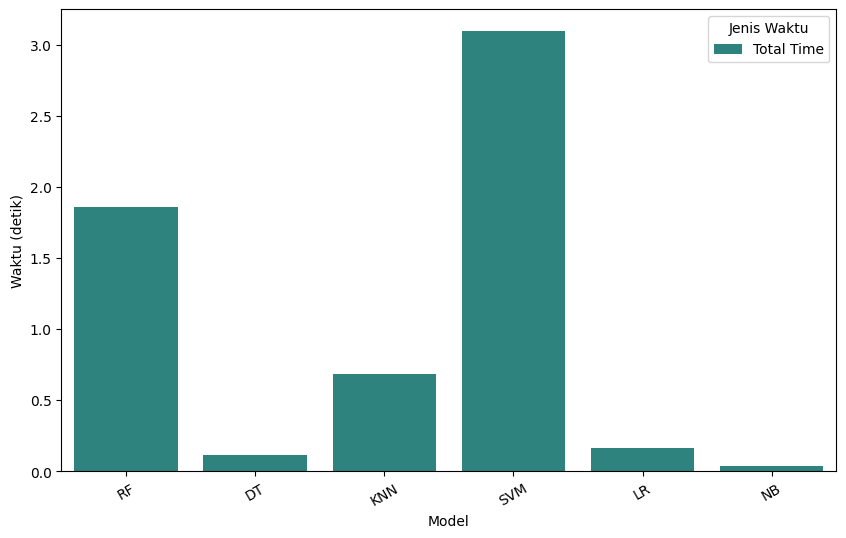

In [5]:
time_df = results_df.melt(
    id_vars="Model",
    value_vars=["Total Time"],
    var_name="Jenis Waktu",
    value_name="Detik"
)

plt.figure(figsize=(10,6))
sns.barplot(data=time_df, x="Model", y="Detik", hue="Jenis Waktu", palette="viridis")
plt.ylabel("Waktu (detik)")
plt.xticks(rotation=30)
plt.show()

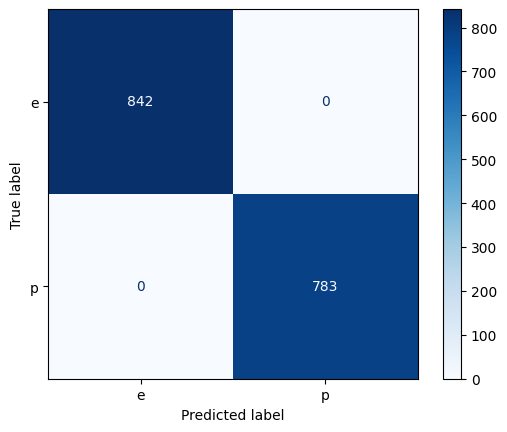

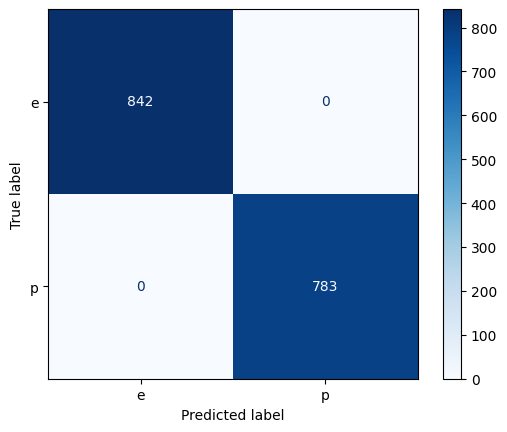

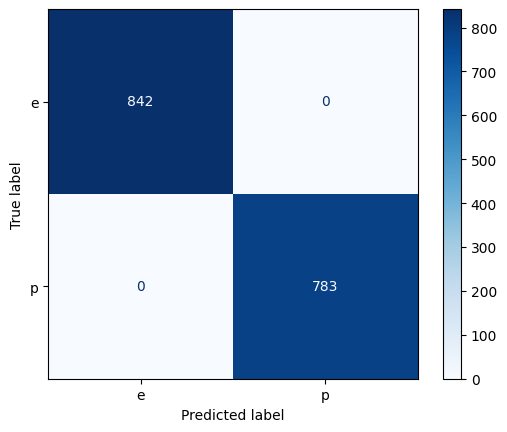

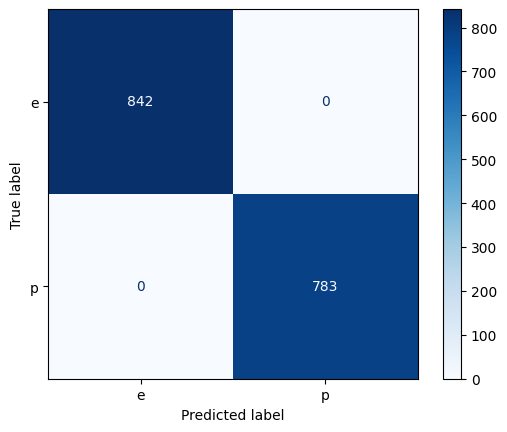

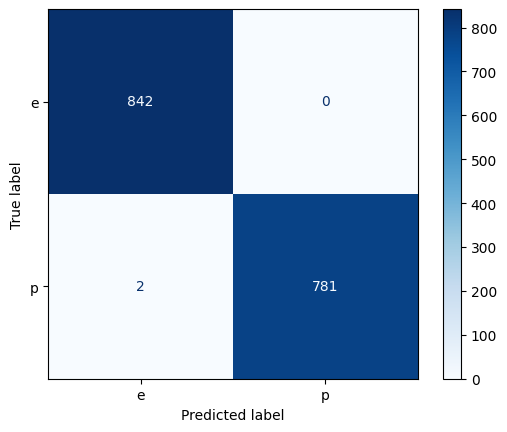

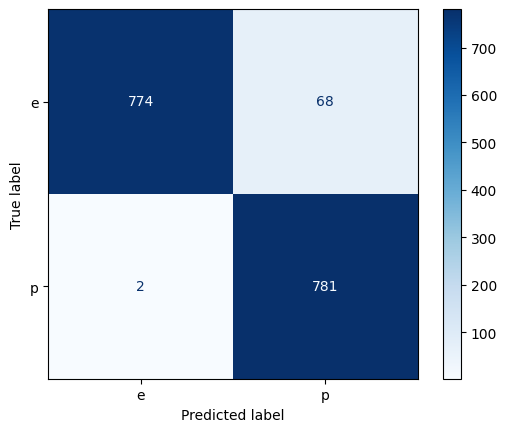

In [6]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues")
    plt.show()

In [7]:
rf_results = []

for n in [50, 100]:
    for depth in [None, 5, 10]:
        for feat in ["sqrt", "log2"]:
            for min_split in [2, 5]:
                model = RandomForestClassifier(
                    n_estimators=n,
                    max_depth=depth,
                    max_features=feat,
                    min_samples_split=min_split,
                    random_state=42
                )
                start_time = time.time()
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                total_time = time.time() - start_time

                rf_results.append({
                    "n_estimators": n,
                    "max_depth": depth,
                    "max_features": feat,
                    "min_samples_split": min_split,
                    "Accuracy": accuracy_score(y_test, y_pred),
                    "F1": f1_score(y_test, y_pred),
                    "Precision": precision_score(y_test, y_pred),
                    "Recall": recall_score(y_test, y_pred),
                    "Total Time": total_time
                })

rf_df = pd.DataFrame(rf_results)
rf_df = rf_df[rf_df["Accuracy"] == 1.0]
pd.set_option("display.float_format", "{:,.10f}".format)
rf_df = rf_df.sort_values(by="Total Time", ascending=True).reset_index(drop=True)


print("RF Results (sorted by total time)")
print(rf_df)

RF Results (sorted by total time)
    n_estimators     max_depth max_features  min_samples_split     Accuracy  \
0             50 10.0000000000         log2                  5 1.0000000000   
1             50 10.0000000000         log2                  2 1.0000000000   
2             50           NaN         sqrt                  2 1.0000000000   
3             50 10.0000000000         sqrt                  5 1.0000000000   
4             50           NaN         log2                  5 1.0000000000   
5             50           NaN         log2                  2 1.0000000000   
6             50           NaN         sqrt                  5 1.0000000000   
7             50 10.0000000000         sqrt                  2 1.0000000000   
8            100 10.0000000000         log2                  5 1.0000000000   
9            100           NaN         log2                  5 1.0000000000   
10           100           NaN         log2                  2 1.0000000000   
11           100 1

In [8]:
dt_results = []

for depth in [None, 5, 10]:
    for crit in ["gini", "entropy"]:
        for min_split in [2, 5]:
            for min_leaf in [1, 2]:
                model = DecisionTreeClassifier(
                    max_depth=depth,
                    criterion=crit,
                    min_samples_split=min_split,
                    min_samples_leaf=min_leaf,
                    random_state=42
                )
                start_time = time.time()
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                total_time = time.time() - start_time

                dt_results.append({
                    "max_depth": depth,
                    "criterion": crit,
                    "min_samples_split": min_split,
                    "min_samples_leaf": min_leaf,
                    "Accuracy": accuracy_score(y_test, y_pred),
                    "F1": f1_score(y_test, y_pred),
                    "Precision": precision_score(y_test, y_pred),
                    "Recall": recall_score(y_test, y_pred),
                    "Total Time": total_time
                })

dt_df = pd.DataFrame(dt_results)
dt_df = dt_df[dt_df["Accuracy"] == 1.0]
pd.set_option("display.float_format", "{:,.10f}".format)
dt_df = dt_df.sort_values(by="Total Time", ascending=True).reset_index(drop=True)


print("DT Results (sorted by total time)")
print(dt_df)


DT Results (sorted by total time)
       max_depth criterion  min_samples_split  min_samples_leaf     Accuracy  \
0  10.0000000000   entropy                  5                 2 1.0000000000   
1            NaN   entropy                  2                 2 1.0000000000   
2            NaN   entropy                  5                 2 1.0000000000   
3            NaN   entropy                  5                 1 1.0000000000   
4  10.0000000000   entropy                  5                 1 1.0000000000   
5            NaN   entropy                  2                 1 1.0000000000   
6  10.0000000000   entropy                  2                 2 1.0000000000   
7            NaN      gini                  5                 2 1.0000000000   
8            NaN      gini                  2                 2 1.0000000000   
9  10.0000000000      gini                  5                 2 1.0000000000   
10 10.0000000000      gini                  2                 2 1.0000000000   
11 10.

In [9]:
knn_results = []

for k in [3, 5, 7, 9, 11]:
    for w in ["uniform", "distance"]:
        for m in ["euclidean", "manhattan"]:
            model = KNeighborsClassifier(
                n_neighbors=k,
                weights=w,
                metric=m
                )
            start_time = time.time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            total_time = time.time() - start_time

            knn_results.append({
                "n_neighbors": k,
                "weights": w,
                "metric": m,
                "Accuracy": accuracy_score(y_test, y_pred),
                "F1": f1_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred),
                "Recall": recall_score(y_test, y_pred),
                "Total Time": total_time
            })

knn_df = pd.DataFrame(knn_results)
pd.set_option("display.float_format", "{:,.10f}".format)
knn_df = knn_df.sort_values(by="Total Time", ascending=True).reset_index(drop=True)


print("KNN Results (sorted by total time)")
print(knn_df)


KNN Results (sorted by total time)
    n_neighbors   weights     metric     Accuracy           F1    Precision  \
0             5   uniform  euclidean 1.0000000000 1.0000000000 1.0000000000   
1             7  distance  euclidean 1.0000000000 1.0000000000 1.0000000000   
2             5  distance  euclidean 1.0000000000 1.0000000000 1.0000000000   
3             9   uniform  euclidean 1.0000000000 1.0000000000 1.0000000000   
4            11  distance  euclidean 1.0000000000 1.0000000000 1.0000000000   
5             3  distance  euclidean 1.0000000000 1.0000000000 1.0000000000   
6             7   uniform  euclidean 1.0000000000 1.0000000000 1.0000000000   
7            11   uniform  euclidean 0.9987692308 0.9987212276 1.0000000000   
8             3   uniform  euclidean 1.0000000000 1.0000000000 1.0000000000   
9             9  distance  euclidean 1.0000000000 1.0000000000 1.0000000000   
10            7   uniform  manhattan 1.0000000000 1.0000000000 1.0000000000   
11            5  

In [10]:
lr_results = []

for c in [0.1, 1.0, 10]:
    for solver in ["lbfgs", "liblinear"]:
        model = LogisticRegression(
            C=c,
            solver=solver,
            max_iter=200,
            random_state=42
        )
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        total_time = time.time() - start_time


        lr_results.append({
            "C": c,
            "solver": solver,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "Total Time": total_time
        })

lr_df = pd.DataFrame(lr_results)
pd.set_option("display.float_format", "{:,.10f}".format)
lr_df = lr_df.sort_values(by="Total Time", ascending=True).reset_index(drop=True)


print("LR Results (sorted by total time)")
print(lr_df)


LR Results (sorted by total time)
              C     solver     Accuracy           F1    Precision  \
0  0.1000000000  liblinear 0.9963076923 0.9961538462 1.0000000000   
1  1.0000000000  liblinear 0.9987692308 0.9987212276 1.0000000000   
2  0.1000000000      lbfgs 0.9963076923 0.9961538462 1.0000000000   
3 10.0000000000  liblinear 1.0000000000 1.0000000000 1.0000000000   
4  1.0000000000      lbfgs 0.9987692308 0.9987212276 1.0000000000   
5 10.0000000000      lbfgs 1.0000000000 1.0000000000 1.0000000000   

        Recall   Total Time  
0 0.9923371648 0.0456938744  
1 0.9974457216 0.0719814301  
2 0.9923371648 0.0897161961  
3 1.0000000000 0.1010215282  
4 0.9974457216 0.1011021137  
5 1.0000000000 0.1118667126  


In [11]:
svm_results = []

for c in [0.1, 1, 10]:
    for kernel in ["linear", "rbf"]:
        for gamma in ["scale", "auto"]:
            model = SVC(
                C=c,
                kernel=kernel,
                gamma=gamma,
                random_state=42
            )
            start_time = time.time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            total_time = time.time() - start_time


            svm_results.append({
                "C": c,
                "kernel": kernel,
                "gamma": gamma,
                "Accuracy": accuracy_score(y_test, y_pred),
                "F1": f1_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred),
                "Recall": recall_score(y_test, y_pred),
                "Total Time": total_time
            })

svm_df = pd.DataFrame(svm_results)
svm_df = svm_df[svm_df["Accuracy"] == 1.0]
pd.set_option("display.float_format", "{:,.10f}".format)
svm_df = svm_df.sort_values(by="Total Time", ascending=True).reset_index(drop=True)


print("SVM Results (sorted by total time)")
print(svm_df)


SVM Results (sorted by total time)
              C  kernel  gamma     Accuracy           F1    Precision  \
0  1.0000000000  linear   auto 1.0000000000 1.0000000000 1.0000000000   
1 10.0000000000  linear   auto 1.0000000000 1.0000000000 1.0000000000   
2  1.0000000000  linear  scale 1.0000000000 1.0000000000 1.0000000000   
3 10.0000000000  linear  scale 1.0000000000 1.0000000000 1.0000000000   
4 10.0000000000     rbf   auto 1.0000000000 1.0000000000 1.0000000000   
5  1.0000000000     rbf  scale 1.0000000000 1.0000000000 1.0000000000   
6 10.0000000000     rbf  scale 1.0000000000 1.0000000000 1.0000000000   

        Recall   Total Time  
0 1.0000000000 0.1463093758  
1 1.0000000000 0.1463959217  
2 1.0000000000 0.1518144608  
3 1.0000000000 0.1541049480  
4 1.0000000000 0.5426433086  
5 1.0000000000 0.8011608124  
6 1.0000000000 0.8592972755  


Naive Bayes Results
   var_smoothing     Accuracy           F1    Precision       Recall  \
0   0.0000000010 0.9569230769 0.9571078431 0.9199057715 0.9974457216   
1   0.0000000100 0.9698461538 0.9695841092 0.9432367150 0.9974457216   
2   0.0000001000 0.9821538462 0.9817724701 0.9665841584 0.9974457216   
3   0.0000010000 0.9889230769 0.9886075949 0.9799247177 0.9974457216   
4   0.0000100000 0.9932307692 0.9930069930 0.9886075949 0.9974457216   
5   0.0001000000 0.9932307692 0.9930069930 0.9886075949 0.9974457216   
6   0.0010000000 0.9932307692 0.9930069930 0.9886075949 0.9974457216   

    Total Time  
0 0.0183620453  
1 0.0151617527  
2 0.0148785114  
3 0.0149850845  
4 0.0145895481  
5 0.0146400928  
6 0.0151927471  


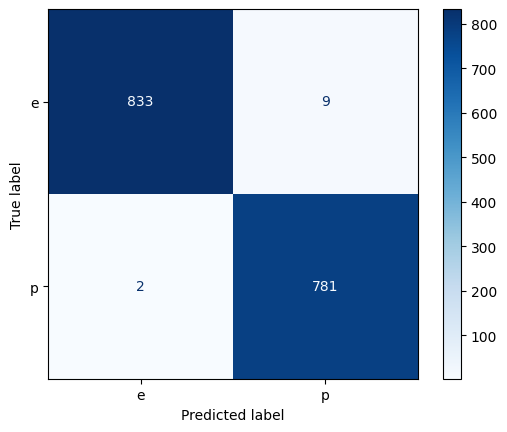

In [12]:
nb_results = []

for vs in [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]:
    model = GaussianNB(var_smoothing=vs)
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    total_time = time.time() - start_time


    nb_results.append({
        "var_smoothing": vs,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Total Time": total_time
    })

nb_df = pd.DataFrame(nb_results)
print("Naive Bayes Results")
print(nb_df)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.show()


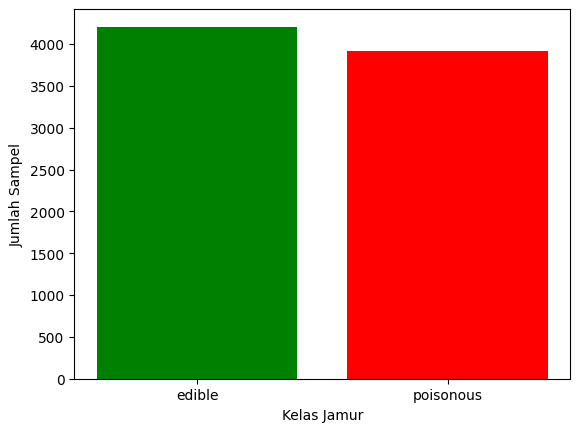

In [13]:
class_counts = df['class'].value_counts()
class_counts.index = class_counts.index.map({'e': 'edible', 'p': 'poisonous'})
plt.bar(class_counts.index, class_counts.values, color=['green', 'red'])
plt.xlabel("Kelas Jamur")
plt.ylabel("Jumlah Sampel")
plt.show()

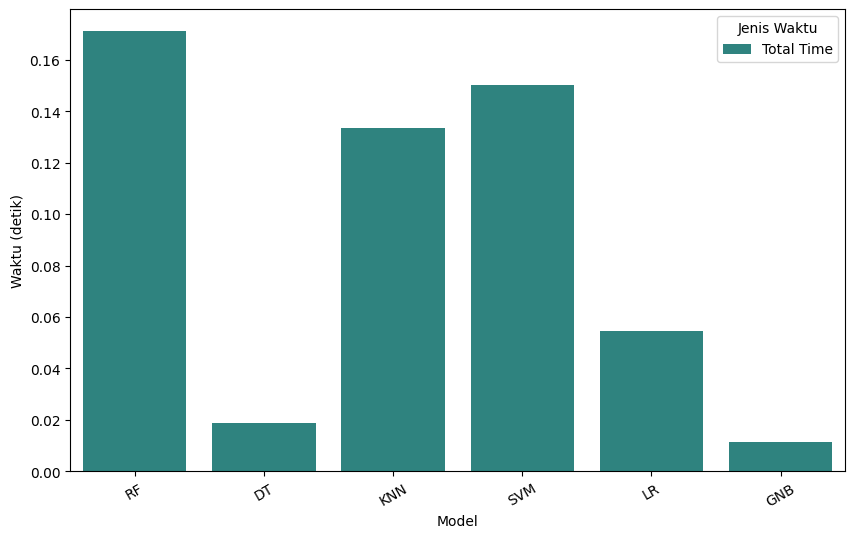

In [14]:
models = ['RF', 'DT', 'KNN', 'SVM', 'LR', 'GNB']
times = [0.1711611748, 0.0188364983, 0.1333863735, 0.1501393318, 0.0544836521, 0.0113170147]

time_df = pd.DataFrame({
    'Model': models,
    'Detik': times,
    'Jenis Waktu': ['Total Time'] * len(models)
})
plt.figure(figsize=(10,6))
sns.barplot(data=time_df, x="Model", y="Detik", hue="Jenis Waktu", palette="viridis")
plt.ylabel("Waktu (detik)")
plt.xticks(rotation=30)
plt.show()
plt.show()


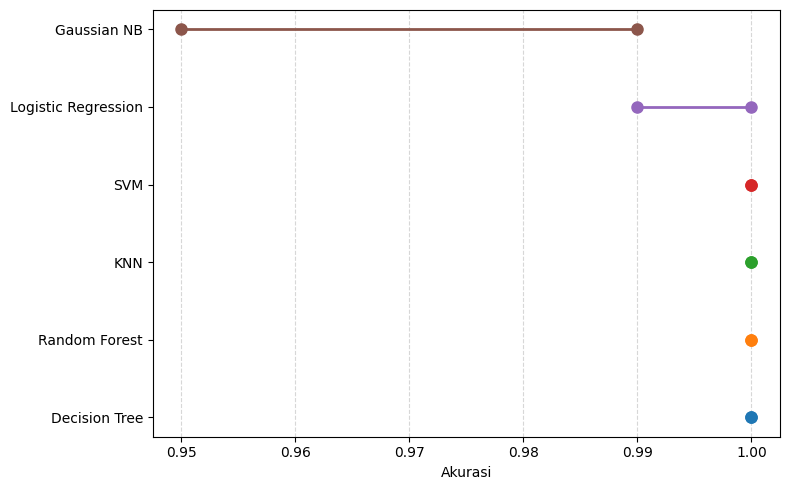

In [15]:
import matplotlib.pyplot as plt
import pandas as pd


data = {
    'Model': ['Decision Tree', 'Random Forest', 'KNN', 'SVM', 'Logistic Regression', 'Gaussian NB'],
    'Default Accuracy': [1.00, 1.00, 1.00, 1.00, 0.99, 0.95],
    'Tuned Accuracy':   [1.00, 1.00, 1.00, 1.00, 1.00, 0.99]
}

df = pd.DataFrame(data)


plt.figure(figsize=(8,5))
for i in range(len(df)):
    plt.plot(
        [df['Default Accuracy'][i], df['Tuned Accuracy'][i]],
        [df['Model'][i], df['Model'][i]],
        'o-', linewidth=2, markersize=8
    )


plt.xlabel('Akurasi')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
